In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tridesclous as tdc
from scipy.signal import iirnotch, lfilter_zi, lfilter, filtfilt, find_peaks
%matplotlib inline

## DataIO

In [4]:
path_wd = 'C:\\Users\\user\\Documents\\Bodo_Rueckauer\\Data\\raw\\Electrical stimulus\\Pig_20191113_Retina#3_SubDGIST_2100_50uA_1ms_ch8'
path_out = os.path.join(path_wd, 'tdc_output2')

if os.path.exists(path_out):
    shutil.rmtree(path_out)   

dataio = tdc.DataIO(path_out)

path_data = os.path.join(path_wd, 'Try2_2019-11-13T18-29-30.h5')
dataio.set_data_source(type='h5', filenames=[path_data])
print(dataio)

Loading .h5 file: C:\Users\user\Documents\Bodo_Rueckauer\Data\raw\Electrical stimulus\Pig_20191113_Retina#3_SubDGIST_2100_50uA_1ms_ch8\Try2_2019-11-13T18-29-30.h5
Recording_0 <HDF5 group "/Data/Recording_0" (2 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (60, 895000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (60,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (1, 895000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (1,), type "|V108">
Stream_0 <HDF5 group "/Data/Recording_0/EventStream/Stream_0" (2 members)>
EventEntity_0 <HDF5 dataset "EventEntity_0": shape (5, 31), type "<i8">
InfoEvent <HDF5 dataset "In

In [6]:
path_probe = os.path.join(path_out, 'electrode_selection.prb')

probe_string = ('''\
n_electrodes = 60
channel_groups = {0: {'channels': list(range(n_electrodes)), 
                      'geometry': {k: [0, k * 200] for k in range(n_electrodes)}}}
''')

# with open(path_probe, 'w') as f:
#     f.write(probe_string)
    
dataio.set_probe_file(path_probe)

## CatalogueConstructor

In [7]:
catalogueconstructor = tdc.CatalogueConstructor(dataio)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp ch12 - ch12
  Signal pre-processing not done yet


In [8]:
catalogueconstructor.set_preprocessor_params(highpass_freq=100, 
                                             lowpass_freq=None, 
                                             relative_threshold=4)

## Median and MAD per channel

In [9]:
catalogueconstructor.estimate_signals_noise()
print(catalogueconstructor.signals_medians)
print(catalogueconstructor.signals_mads)

[2.6054033e-07]
[6.730112e-06]


## Signal preprocessing and peak detection

In [10]:
catalogueconstructor.run_signalprocessor(duration=100)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp ch12 - ch12
  nb_peak_by_segment: 3070
  cluster_labels [-11]



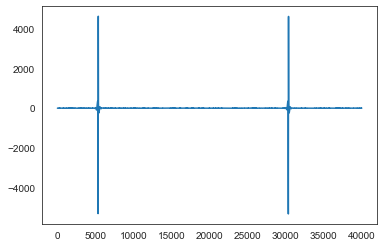

In [11]:
plt.plot(dataio.arrays['ch12'][0].get('processed_signals')[60000:100000, 0])

### Attempts to remove stimulus artifacts

In [14]:
artifact_data = dataio.datasource.array_sources[0][:, 20]

In [22]:
# Using Independent Component Analysis
from sklearn.decomposition import FastICA
ica = FastICA(2)
filtered_data1 = ica.fit_transform(np.reshape(artifact_data, (-1, 10), 'F'))

In [41]:
# Using notch filter
fs = 25000  # Sampling rate
f0 = 1  # Frequency to be removed from signal (Hz)
Q = 30  # Quality factor
w0 = f0 / (fs / 2)  # Normalized Frequency
b, a = iirnotch(f0, Q, fs)  # Design notch filter
zi = lfilter_zi(b, a)
filtered_data2, _ = lfilter(b, a, artifact_data, zi=zi*artifact_data[0])
filtered_data3, _ = lfilter(b, a, filtered_data2, zi=zi*filtered_data2[0])
filtered_data4 = filtfilt(b, a, artifact_data)

In [16]:
# Using brute force: Detect artifacts by thresholding, and set to zero.
relative_threshold = 10
diff_abs = np.abs(np.diff(artifact_data))
diff_abs = np.insert(diff_abs, -1, 0)
mad = np.median(np.abs(artifact_data - np.median(artifact_data)))
mask_a = np.abs(artifact_data) > relative_threshold * mad
mask_b = diff_abs > relative_threshold * mad

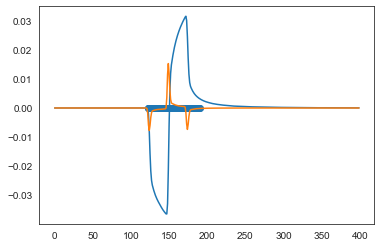

In [19]:
idxs = slice(65200, 65600)
plt.plot(artifact_data[idxs])
plt.plot(diff_abs[idxs])
x = np.flatnonzero(mask_b[idxs])
plt.scatter(x, np.zeros_like(x))
# plt.ylim(-0.0001, 0.0001)

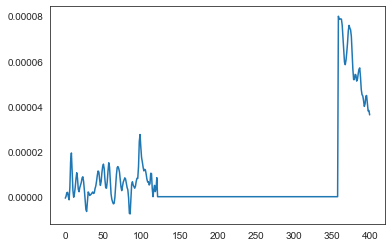

In [144]:
# plt.plot(artifact_data[idxs])
clean_data_a = np.where(mask_a, 0, artifact_data)
# plt.plot(clean_data_a[idxs])
clean_data_b = np.where(mask_b, 0, artifact_data)
# plt.plot(clean_data_b[idxs])
clean_data_c = np.where(np.bitwise_or(mask_a, mask_b), 0, artifact_data)
plt.plot(clean_data_c[idxs])
# plt.ylim(-0.0001, 0.0001)

In [18]:
diff = np.diff(artifact_data)
mad_diff = np.median(np.abs(diff - np.median(diff)))
mask_diff = find_peaks(diff, 15 * mad_diff, distance=2500)
# trigger_data = np.flatnonzero(mask_diff)

## Extract a few waveforms

In [31]:
catalogueconstructor.extract_some_waveforms(wf_left_ms=-2, wf_right_ms=3)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  nb_peak_by_segment: 131520
  some_waveforms.shape: (9628, 125, 60)
  cluster_labels [-11   0]



## Remove outlier spikes

In [32]:
catalogueconstructor.clean_waveforms()
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  nb_peak_by_segment: 131520
  some_waveforms.shape: (9628, 125, 60)
  cluster_labels [-11   0]



## Feature extraction

In [33]:
# catalogueconstructor.extract_some_features(method='pca_by_channel',
#                                            n_components_by_channel=4)
catalogueconstructor.extract_some_features(method='neighborhood_pca',
                                           n_components_by_neighborhood=4,
                                           radius_um=300)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  nb_peak_by_segment: 131520
  some_waveforms.shape: (9628, 125, 60)
  some_features.shape: (9628, 240)
  cluster_labels [-11   0]



## Clustering

In [34]:
catalogueconstructor.find_clusters(method='gmm', n_clusters=3)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  nb_peak_by_segment: 131520
  some_waveforms.shape: (9628, 125, 60)
  some_features.shape: (9628, 240)
  cluster_labels [-11   0   1   2]



## Visual check in CatalogueWindow

In [35]:
%gui qt5
import pyqtgraph as pg
app = pg.mkQApp()
win = tdc.CatalogueWindow(catalogueconstructor)
win.show()
app.exec_()    

Exception: Plot data must be 1D ndarray.

0

## Peeler

In [ ]:
catalogueconstructor.make_catalogue_for_peeler()
initial_catalogue = dataio.load_catalogue()

peeler = tdc.Peeler(dataio)
peeler.change_params(initial_catalogue)

peeler.run()

print("Number of spikes: {}".format(dataio.get_spikes(0).size))

## Visual check in PeelerWindow

In [ ]:
%gui qt5
import pyqtgraph as pg
app = pg.mkQApp()
win = tdc.PeelerWindow(dataio=dataio, catalogue=initial_catalogue)
win.show()
app.exec_()